<a href="https://colab.research.google.com/github/ImanNoferesti/TensorFlow_DeepDive/blob/main/Malaria_Diagnosis_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [242]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import sklearn
import seaborn as sns
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input, Layer, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, TruePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
from sklearn.metrics import confusion_matrix, roc_curve


# Data Prepration

## Data Loading

The function `tfds.load()` is used to load datasets from TensorFlow Datasets (TFDS), a collection of ready-to-use datasets for machine learning.

Parameters:

* `name`: The name of the dataset (e.g., 'mnist', 'cifar10').

* `split`: Specifies the data subset to load (e.g., 'train', 'test').

* `as_supervised`: If set to `True`, it returns the dataset in the form `(input, label)` pairs.

* `batch_size`: Allows you to load the dataset in batches.

In [106]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [243]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [244]:
dataset

for data in dataset[0].take(3):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [245]:
# Create a dataset containing a range of numbers from 0 to 9
dataset = tf.data.Dataset.range(10)
# Skip the first 7 elements, resulting in a dataset starting from the 7th element (index 7)
taken_after_skipping_dataset = dataset.skip(7)
taken_dataset = dataset.take(3)
# Convert the dataset to a list of numpy arrays and print it
print(list(taken_after_skipping_dataset.as_numpy_iterator()))
print(list(taken_dataset.as_numpy_iterator()))

[7, 8, 9]
[0, 1, 2]


In [246]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [247]:
# Example for understanding how the split function should perform

dataset = tf.data.Dataset.range(10)
dataset_size = len(dataset)

train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
print(list(train_dataset.as_numpy_iterator()))

val_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size)).take(int(VAL_RATIO * dataset_size))
print(list(val_dataset.as_numpy_iterator()))

test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * dataset_size))
print(list(test_dataset.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7]
[8]
[9]


In [248]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  dataset_size = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
  val_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size)).take(int(VAL_RATIO * dataset_size))
  test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * dataset_size))

  return train_dataset, val_dataset, test_dataset


In [249]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

train_dataset, val_dataset, test_dataset = split(dataset[0],TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


## Data Visualization

The `enumerate()` function in Python is a built-in function that adds a counter to an iterable and returns it as an `enumerate` object. This allows you to loop over an iterable (like a list, tuple, or dataset) and keep track of the index at the same time.

How `enumerate()` Works:

* `enumerate(iterable, start=0)` takes two parameters:
  * `iterable`: The sequence (like a list or dataset) that you want to iterate over.
  * `start`: The starting value for the counter (default is `0`).


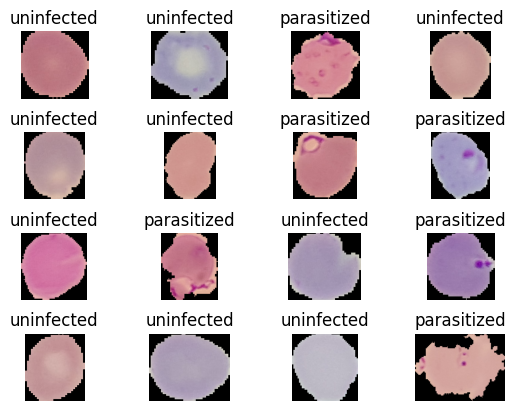

In [250]:
# Iterate over the first 16 images and labels in the training dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
  # Create a subplot with 4 rows and 4 columns
  # The current subplot is determined by i+1 (1-based index)
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Data Preprocessing

## Data Augmentation

Image Augmentation is a technique used in machine learning to artificially expand the size and diversity of a training dataset by applying random transformations to images. This helps improve model generalization, reduces overfitting, and enhances robustness.

In [251]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [252]:
original_image, label = next(iter(train_dataset))

Common Augmentation Techniques:

1. Geometric Transformations:
  * Flipping: `tf.image.flip_left_right(image)`
  * Rotation: `tfa.image.rotate(image, angles=0.1)`
  * Cropping: `tf.image.random_crop(image, size=[height, width, channels])`

  * Resizing: `tf.image.resize(image, [new_height, new_width])`

2. Color Adjustments:
  * Brightness: `tf.image.random_brightness(image, max_delta=0.2)`

  * Contrast: `tf.image.random_contrast(image, lower=0.8, upper=1.2)`

  * Saturation: `tf.image.random_saturation(image, lower=0.5, upper=1.5)`

  * Hue: `tf.image.random_hue(image, max_delta=0.1)`

3. Noise Addition:
  * `noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)`
  * `noisy_image = tf.add(image, noise)`

4. Normalization:
  * `tf.image.per_image_standardization(image)`


More: https://www.tensorflow.org/api_docs/python/tf/image


https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomBrightness

https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast

https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop

.
.
.




In [253]:
augmented_image = tf.image.flip_left_right(original_image)

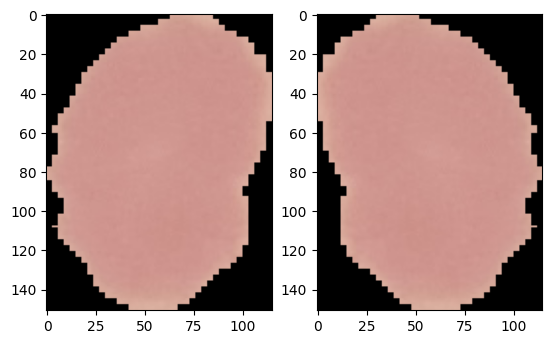

In [254]:
visualize(original_image, augmented_image)

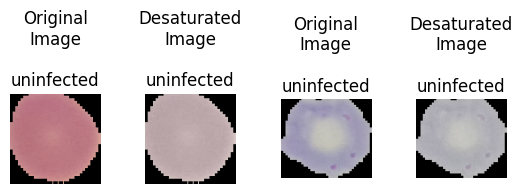

In [255]:
# Iterate over the first 2 images and labels in the training dataset
for i, (image, label) in enumerate(train_dataset.take(2)):
  # Create a subplot with 1 rows and 4 columns
  # The current subplot is determined by i+1 (1-based index)
  plt.subplot(1,4,2*i+1)
  plt.imshow(image)

  plt.title("Original\nImage\n\n" + dataset_info.features['label'].int2str(label))
  plt.axis('off')

  plt.subplot(1,4,2*i+2)
  plt.imshow(tf.image.adjust_saturation(image, saturation_factor=0.3))

  plt.title("Desaturated\nImage\n\n" + dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

The `tf.image.resize()` function in TensorFlow is used to resize images to a specified size. This function is particularly useful in image preprocessing for machine learning models, where input images need to be of uniform dimensions.

Parameters:

* `images`: The input image or batch of images to be resized. It should be a 3D (single image) or 4D (batch of images) tensor.

* `size`: A 1-D tensor or list specifying the new size `[new_height, new_width]`.

* `method`: The interpolation method used for resizing. Options include `'bilinear'`, `'nearest'`, `'bicubic'`, and `'lanczos3'`, among others. The default is `'bilinear'`.

* `preserve_aspect_ratio`: If `True`, the function preserves the original aspect ratio of the image while resizing.

* `antialias`: If `True`, an anti-aliasing filter is applied when resizing. This can help reduce visual artifacts.

* `name`: An optional name for the operation.

In [256]:
# Normalization =>  x = (x - xmin) / (xmax - xmin) In our case xmin = 0 pixels and xmax = 255

IM_SIZE = 224
x_max = 255.0

def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/x_max, label

In [263]:
# Resize and Rescale using tf.keras.layer
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255)
])


In [258]:
# Augmentation using tf.image
def augment(image, label):
  image, label = resize_rescale(image, label)
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image, label

In [259]:
# Augmentation using tf.keras.layer
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode='HORIZONTAL')
])

def augment_layer(image, label):
  # Apply resize_rescale_layers only to the image part of the tuple
  return augment_layers(resize_rescale_layers(image),training =True), label

The `map()` function in TensorFlow's `tf.data.Dataset` API is used to apply a specified function to each element of the dataset. This is helpful for preprocessing data, such as resizing images, normalizing data, or augmenting images, before they are used for training or evaluation in a machine learning model.

Use Cases for `map()`:

* **Preprocessing images**: Resize, normalize, or augment images.
* **Data transformation**: Apply data type conversions or feature scaling.
* **Feature extraction**: Extract or compute additional features from the data.

## Data Partitioning

In [267]:
#test_dataset = test_dataset.map(resize_rescale)

# Wrap the Sequential model in a lambda function or define a mapping function
test_dataset = test_dataset.map(lambda x, y: (resize_rescale_layers(x), y)) # Using new function (keras)

In [203]:
# Shuffle the dataset, batch it into groups of 32, and prefetch data for optimal pipeline performance
train_dataset = (
    train_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(augment)
    .map(augment_layer)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
    )

In [268]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(resize_rescale)
    .map(lambda x, y: (resize_rescale_layers(x), y))
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
    )

In [182]:
# for image, label in train_dataset.take(1):
#   print(image, label)

# Model Creation

CNN Explainer: https://poloclub.github.io/cnn-explainer/

CNN For Visual Recognition: https://cs231n.github.io/

CNN Arithmetic: https://github.com/vdumoulin/conv_arithmetic

To calculate the output dimensions of a feature map after applying a convolutional operation in a convolutional neural network (CNN), considering filter size, stride, and padding, is:

$$
W_{out} = \left\lfloor \frac{W_{in} - F + 2P}{S} \right\rfloor + 1
$$

$$
H_{out} = \left\lfloor \frac{H_{in} - F + 2P}{S} \right\rfloor + 1
$$

Definitions:

* `Wout` and `Hout`: The width and height of the output feature map.

* `Win` and `Hin`: The width and height of the input feature map.

* `F`: The filter size (kernel size).

* `P`: The amount of zero-padding applied to the input.

* `S`: The stride, which is the step size that the filter moves across the input.

* `⌊ ⌋`: The floor function, which rounds down to the nearest integer.

Image Kernels: https://setosa.io/ev/image-kernels/


An **image kernel**, also known as a filter or convolution kernel, is a small matrix used in image processing and computer vision to perform various operations on images, such as blurring, sharpening, edge detection, and more. The kernel is applied to an image through a process called convolution, where the kernel matrix slides over the image, performing element-wise multiplications and summing the results to produce a new pixel value.

Key Concepts:

1. **Kernel Size**: The kernel is usually a square matrix (e.g., 3x3, 5x5) that defines the area of pixels considered in the operation. Common sizes include 3x3 and 5x5.

2. **Convolution Process:**

  * The kernel is placed over the image such that its center aligns with a specific pixel.

  * Each value in the kernel is multiplied by the corresponding pixel value beneath it.

  * The products are summed up to produce a single output pixel.

  * The kernel then moves to the next pixel, and the process repeats.

3. **Types of Kernels:**

  * **Blurring Kernel**: Averages the surrounding pixel values, creating a smooth image. Example:
  $$
\text{Gaussian Kernel} = \begin{bmatrix}
\frac{1}{16} & \frac{2}{16} & \frac{1}{16} \\
\frac{2}{16} & \frac{4}{16} & \frac{2}{16} \\
\frac{1}{16} & \frac{2}{16} & \frac{1}{16}
\end{bmatrix}
$$

  * **Sharpening Kernel**: Enhances edges by amplifying differences between neighboring pixels. Example:

  $$
\text{Laplacian Kernel} = \begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{bmatrix}
$$

  * **Edge Detection Kernel**: Identifies edges in an image by highlighting areas of high contrast. Example:

  $$
\text{Sobel Kernel} = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

4. **Padding**: To ensure that the kernel can process the edges of an image without losing information, padding (usually zero-padding) may be added around the image.

5. **Stride**: The stride defines how many pixels the kernel moves at a time. A stride of 1 means it moves one pixel at a time, while a stride of 2 skips every other pixel.



**Max pooling** is a downsampling technique commonly used in convolutional neural networks (CNNs) to reduce the spatial dimensions (width and height) of feature maps while retaining the most important information. It operates by partitioning the input feature map into a set of non-overlapping rectangles and taking the maximum value from each rectangle. This process helps to summarize the features in the region and reduces the computational load for subsequent layers in the network.

Key Concepts:

1. **Operation**:
  * The max pooling operation is typically defined by a **kernel size** (also called the pooling window) and a **stride** (the step size for moving the window).

    *  For example, with a 2x2 max pooling operation and a stride of 2, the pooling layer will cover a 2x2 area of the input feature map, take the maximum value from that area, and move to the next non-overlapping 2x2 region.

2. **Formulation**:
  * Given an input feature map \(X\), the output feature map \(Y\) after applying max pooling can be defined as:

   $$
   Y_{i,j} = \max(X_{a,b}) \quad \text{for } a, b \text{ in the pooling window}
   $$

   where \(i\) and \(j\) are the indices of the output feature map, and \(a\) and \(b\) are the indices of the corresponding region in the input feature map.

3. **Benefits**:
  * **Dimensionality Reduction**: By reducing the size of the feature maps, max pooling decreases the number of parameters and computations in the network, which helps to prevent overfitting.

  * **Translation Invariance**: Max pooling helps the network to become less sensitive to small translations in the input, as the most prominent features (the maximum values) are preserved.

4. **Pooling Size and Stride**:
  * Common choices for the pooling size are 2x2 or 3x3, with a stride often equal to the pooling size to ensure non-overlapping regions.

  * If a stride is smaller than the pooling size, it results in overlapping pooling regions.


Example:

Given the following 4x4 input feature map:

$$
   X = \begin{bmatrix}
   1 & 3 & 2 & 4 \\
   5 & 6 & 2 & 1 \\
   3 & 2 & 1 & 0 \\
   4 & 5 & 6 & 7
   \end{bmatrix}
   $$

   If we apply 2x2 max pooling with a stride of 2, the output will be:

   $$
   Y = \begin{bmatrix}
   6 & 4 \\
   5 & 7
   \end{bmatrix}
   $$
   
   Here, the maximum values from each 2x2 region are taken.

-

`tf.keras.layers.Conv2D()` is a 2D convolutional layer in TensorFlow/Keras, primarily used in building convolutional neural networks (CNNs) for processing image data. It performs the convolution operation, which involves sliding a filter (or kernel) over the input image and computing the dot product between the filter and the input at each position. This process helps extract spatial features like edges, textures, and patterns.

Key Parameters:

* `filters`: The number of output filters (i.e., the number of feature maps produced).

* `kernel_size`: The dimensions of the filter (e.g., (3, 3)).

* `strides`: The step size for moving the filter across the input.

* `padding`: Specifies how the borders of the input are handled, either `'valid'` (no padding) or `'same'` (padding to keep the output size consistent).

* `activation`: The activation function applied to the output (e.g., 'relu').



`tf.keras.layers.MaxPool2D()` is a max pooling layer in TensorFlow/Keras, used in convolutional neural networks (CNNs) to reduce the spatial dimensions of the input, thereby decreasing the number of parameters and computational load while retaining the most important features.

Max pooling operates by dividing the input into smaller rectangular regions (defined by `pool_size`) and selecting the maximum value from each region. This process helps make the network more robust to small translations and variations in the input image.

Key Parameters:

* `pool_size`: The size of the pooling window, typically (2, 2) to reduce the input dimensions by half.

* `strides`: The step size for moving the pooling window across the input. Defaults to the `pool_size` if not specified.

* `padding`: Can be `'valid'` (no padding) or `'same'` (padding added to maintain the same output dimensions).

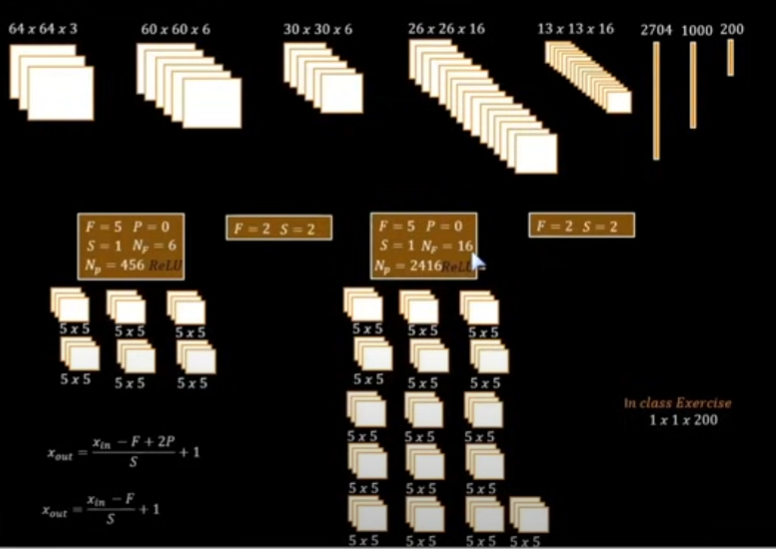

## Understanding Model APIs

In TensorFlow, there are three main ways to build neural network models:



1. **Sequential API:**

* **Use Case**: Best for simple, linear stacks of layers where each layer has exactly one input tensor and one output tensor.

* **Structure:** The model is defined as a linear stack of layers using `tf.keras.Sequential()`.

* **Pros**: Easy to use and straightforward.

* **Cons**: Not flexible for models with multiple inputs/outputs or complex architectures.

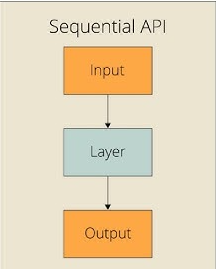

2. **Functional API:**

* **Use Case**: Suitable for more complex models like multi-input/output models, directed acyclic graphs, or models that reuse layers.

* **Structure**: Uses `tf.keras.layers` and connects them in a graph-like structure by specifying input and output tensors.

* **Pros**: More flexible than the Sequential API, supports non-linear topology and layer reusability.

* **Cons**: Slightly more complex to write and read compared to the Sequential API.

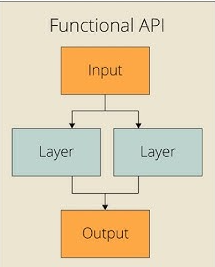


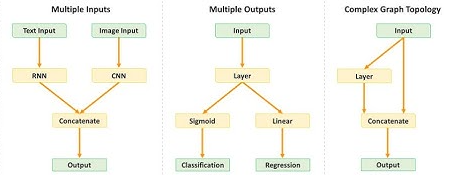

3. **Subclassing API:**

* **Use Case**: Provides the most flexibility, allowing you to define custom architectures by subclassing `tf.keras.Model` and defining the `call` method.

* **Structure**: The user inherits from `tf.keras.Model` and implements the `__init__` and `call` methods.

* **Pros**: Offers full customization for complex models and behavior.
* **Cons**: Requires more code and may be harder to read and maintain compared to the other APIs.

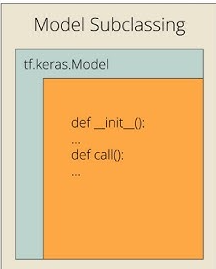

### Sequential API


In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

#### Overfitting and Underfitting

##### Dropout

`tf.keras.layers.Dropout()` is a regularization layer in TensorFlow used to reduce overfitting during training of a neural network. It works by randomly setting a fraction of input units (neurons) to zero during each training step. This prevents the model from becoming overly reliant on specific neurons, thus improving its generalization capability.

**Key Parameters:**
* `rate`: The fraction of input units to drop (e.g., `rate=0.5` drops 50% of units).

* `seed`: (Optional) A random seed for reproducibility.

In [ ]:
# Applying dropout to the model

dropout_rate = 0.5

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate = dropout_rate),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

##### Regularization

`tf.keras.regularizers.L2` is a regularization method in TensorFlow that applies an L2 penalty (also known as weight decay) to the weights of a layer. This technique helps reduce overfitting by discouraging the model from learning overly large weights, which can lead to a more generalizable model.


**Formula:**

The L2 regularization term is computed as:

$$
L2\space penalty=λ ∑ ω^2
$$

where:

* w are the weights of the layer.
* λ (the regularization factor) is the strength of the penalty.

This penalty is added to the loss function during training but does not affect the prediction step.

In [ ]:
# Applying regulizer to the model

regularization_rate = 0.01
dropout_rate = 0.5

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer= L2(regularization_rate)), # Adding L2 Regularizer
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate = dropout_rate),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_regularizer= L2(regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu', kernel_regularizer= L2(regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation='relu', kernel_regularizer= L2(regularization_rate)),
    BatchNormalization(),

    Dense(1, activation='sigmoid')
])

lenet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Functional API

`tensorflow.keras.layers.Input()` is a function in TensorFlow used to instantiate a Keras tensor. It defines the starting point for building a model in the Functional API by specifying the shape and data type of the input data. This tensor serves as the input layer of the model.

Key Points:

* **Purpose**: It creates an input node for the computational graph and acts as a placeholder for the input data.

* **Parameters**:

  * `shape`: Specifies the shape of the input data, excluding the batch size. For example, `shape=(32,)` means the input has 32 features.
  
  * `dtype`: Specifies the data type of the input (default is `float32`).

  * `name`: Optional; assigns a name to the input layer.

-

`tf.keras.Model()` is a class in TensorFlow used to create a model object. It represents the architecture of a neural network and acts as a container that groups layers together to define a complete model. You can use this class to build models using the Functional or Subclassing API in Keras.

Key Points:

* **Usage**: Suitable for more complex architectures like multi-input, multi-output models, and non-linear structures.

* **Parameters**:
  * `inputs`: The input tensor(s) for the model.
  * `outputs`: The output tensor(s) for the model.
  * `name`: Optional; assigns a name to the model.

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name= "Input Image")

x= Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x= BatchNormalization()(x)
x= MaxPool2D(pool_size=2, strides=2)(x)

x= Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x= BatchNormalization()(x)
output= MaxPool2D(pool_size=2, strides=2)(x)



feature_extractor_model = Model(func_input, output, name="Feature_Extractor")

feature_extractor_model.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2)

])

feature_extractor_seq_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

##### Callable Model

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name= "Input Image")

x= feature_extractor_model(func_input)
x= Flatten()(x)

x= Dense(100, activation='relu')(x)
x= BatchNormalization()(x)

x= Dense(10, activation='relu')(x)
x= BatchNormalization()(x)

func_output= Dense(1, activation='sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name="Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Feature_Extractor (Functional)       │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name= "Input Image")

x= feature_extractor_seq_model(func_input)
x= Flatten()(x)

x= Dense(100, activation='relu')(x)
x= BatchNormalization()(x)

x= Dense(10, activation='relu')(x)
x= BatchNormalization()(x)

func_output= Dense(1, activation='sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name="Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 54, 54, 16)          │           1,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

### Model Subclassing


In [ ]:
class Feature_Extractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(Feature_Extractor, self).__init__()

    # First convolutional block
    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size, strides=2*strides)

    # Second convolutional block
    self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size, strides=2*strides)

  def call(self, x):
    # Forward pass through the first convolutional block
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    # Forward pass through the second convolutional block
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = Feature_Extractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)



In [ ]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name= "Input Image")

x= feature_sub_classed(func_input)
x= Flatten()(x)

x= Dense(100, activation='relu')(x)
x= BatchNormalization()(x)

x= Dense(10, activation='relu')(x)
x= BatchNormalization()(x)

func_output= Dense(1, activation='sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name="Lenet_Model")

lenet_model_func.summary()

Model: "Lenet_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature__extractor                   │ (None, 54, 54, 16)          │           1,488 │
│ (Feature_Extractor)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    # Feature extraction block (using the Feature_Extractor subclass)
    self.feature_extractor = Feature_Extractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)
    # Flatten layer to reshape the feature map into a vector
    self.flatten = Flatten()
    # First dense (fully connected) layer with batch normalization
    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    # Second dense layer with batch normalization
    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()
    # Output dense layer with sigmoid activation for binary classification
    self.dense_3 = Dense(1, activation='sigmoid')


  def call(self, x):
    # Forward pass through the feature extractor
    x = self.feature_extractor(x)
    # Flatten the output from the feature extractor
    x = self.flatten(x)
    # Forward pass through the first dense block
    x = self.dense_1(x)
    x= self.batch_1(x)
    # Forward pass through the second dense block
    x = self.dense_2(x)
    x = self.batch_2(x)
    # Output layer
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()

# Test the model with a dummy input tensor of shape (1, 224, 224, 3)
lenet_sub_classed(tf.zeros([1,224,224,3]))

lenet_sub_classed.summary()



Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature__extractor_1                 │ ?                           │           1,488 │
│ (Feature_Extractor)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (1, 46656)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (1, 100)                    │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (1, 100)                    │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (1, 10)                     │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

#### Custom Layers

A custom Dense layer class that extends the `Layer` class provided by TensorFlow's Keras module.

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units # The number of neurons in this layer (output size).
    self.activation = activation  # The activation function to be applied. It supports "relu", "sigmoid", and no activation (linear).

  # Create the weights and biases for the layer based on input shape.
  def build(self, input_features_shape):
    self.w = self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True) # Initialize the weights matrix with a shape of (num_features, output_units) | The weights will be updated during training
    self.b = self.add_weight(shape=(self.output_units,), initializer = "random_normal", trainable = True) # Initialize the bias vector with a shape of (output_units,)

  # Define the forward pass computation for the layer.
  def call(self, input_features):
    if(self.activation == "relue"):
      return tf.nn.relu(tf.matmul(input_features, self.w) + self.b)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(tf.matmul(input_features, self.w) + self.b)
    else:
      # Compute the linear transformation Z = XW + b
      return tf.matmul(input_features, self.w) + self.b

In [ ]:
lenet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(100, activation='relu'),
    BatchNormalization(),

    NeuralearnDense(10, activation='relu'),
    BatchNormalization(),

    NeuralearnDense(1, activation='sigmoid')
])

lenet_custom_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense (NeuralearnDense)   │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_1 (NeuralearnDense) │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neuralearn_dense_2 (NeuralearnDense) │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

##### Model Training

In [ ]:
lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.01),
                          loss = BinaryCrossentropy(),
                          metrics=['accuracy'])

In [ ]:
history = lenet_sub_classed.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.4931 - loss: 1.1504 - val_accuracy: 0.4933 - val_loss: 0.6945
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.4998 - loss: 0.6938 - val_accuracy: 0.4962 - val_loss: 0.6944
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 76ms/step - accuracy: 0.5001 - loss: 0.6938 - val_accuracy: 0.4947 - val_loss: 0.6944
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 85s 80ms/step - accuracy: 0.4987 - loss: 0.6937 - val_accuracy: 0.4966 - val_loss: 0.6945
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.4986 - loss: 0.6938 - val_accuracy: 0.4966 - val_loss: 0.6943


In [ ]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.01),
                          loss = BinaryCrossentropy(),
                          metrics=['accuracy'])

In [ ]:
history = lenet_custom_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.7037 - loss: 0.5775 - val_accuracy: 0.9027 - val_loss: 0.3358
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - accuracy: 0.9044 - loss: 0.2876 - val_accuracy: 0.9078 - val_loss: 0.2625
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.9281 - loss: 0.2235 - val_accuracy: 0.8991 - val_loss: 0.2806
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.9329 - loss: 0.2006 - val_accuracy: 0.9350 - val_loss: 0.2469
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 75s 71ms/step - accuracy: 0.9395 - loss: 0.1794 - val_accuracy: 0.9172 - val_loss: 0.2665


`tf.keras.losses.BinaryCrossentropy()` is a loss function in TensorFlow/Keras used for binary classification problems, where the output can be one of two classes (e.g., 0 or 1). It measures the difference between the true labels and the predicted probabilities, effectively quantifying how well the model's predictions match the actual outcomes.

How It Works:

Binary cross-entropy calculates the loss for each example by comparing the predicted probability (`p`) with the true label (`y`). The formula for binary cross-entropy is:

$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

where:

* `N` is the number of samples.

* $y_i$ is the true label for the ith sample (0 or 1).

* $p_i$  is the predicted probability for the ith sample.

Key Parameters:

* **from_logits**: Boolean indicating whether the predictions are given as logits (unnormalized scores) or probabilities (values between 0 and 1). If `True`, the function will apply a `sigmoid` activation before computing the loss.

* **label_smoothing**: A value between 0 and 1 used to smooth the labels. This can help make the model more robust to overconfident predictions.

### Callbacks

`tf.keras.callbacks` is a module in TensorFlow's Keras API that provides tools to monitor and influence the training process of a machine learning model. Callbacks are functions or objects that are executed at specific stages of training, such as at the start or end of an epoch, batch, or training. They allow you to customize the training process, track metrics, save models, or dynamically adjust hyperparameters.

**Common Callbacks in** `tf.keras.callbacks`:

1. `EarlyStopping`: Stops training when a monitored metric (e.g., validation loss) stops improving after a certain number of epochs.

2. `ModelCheckpoint`: Saves the model at specified intervals or when certain conditions are met, like improved validation accuracy.

3. `TensorBoard`: Logs metrics for visualization in TensorBoard during training.

4. `ReduceLROnPlateau`: Reduces the learning rate when a monitored metric stops improving.

5. `LearningRateScheduler`: Dynamically adjusts the learning rate according to a custom schedule.

6. `CSVLogger`: Logs training metrics to a CSV file.

7. `TerminateOnNaN`: Stops training if NaN values are detected in the loss.

`tf.keras.callbacks.Callback` is the base class for creating custom callbacks in Keras. You can subclass it to define your own behavior at specific stages of the training process. This allows you to execute custom code during or after each epoch, batch, or at the beginning or end of training.

**Key Methods in** `tf.keras.callbacks.Callback`:

1. `on_train_begin(logs=None)`: Called at the start of training.

2. `on_train_end(logs=None)`: Called at the end of training.

3. `on_epoch_begin(epoch, logs=None)`: Called at the start of each epoch.

4. `on_epoch_end(epoch, logs=None)`: Called at the end of each epoch.

5. `on_batch_begin(batch, logs=None)`: Called at the start of each batch.

6. `on_batch_end(batch, logs=None)`: Called at the end of each batch.

7. `on_train_batch_begin(batch, logs=None)`: Called at the start of each batch in training.

8. `on_train_batch_end(batch, logs=None)`: Called at the end of each batch in training.

9. `on_test_begin(logs=None)`: Called at the start of testing.

10. `on_test_end(logs=None)`: Called at the end of testing.

11. `on_predict_begin(logs=None)`: Called at the start of prediction.

12. `on_predict_end(logs=None)`: Called at the end of prediction.

The `logs` parameter is a dictionary containing metrics and information about the training process at that point.

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print(f'\nFor Epoch Number {epoch+1}, the model has a loss of {logs["loss"]}')

"""
  def on_batch_end(self, batch, logs):
    print(f'\nFor Batch Number {epoch+1}, the model has a loss of {logs}')

"""

"\n  def on_batch_end(self, batch, logs):\n    print(f'\nFor Batch Number {epoch+1}, the model has a loss of {logs}')\n\n"

In [ ]:
# Applying callbacks
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1, callbacks=[LossCallback()])

Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9454 - auc: 0.9786 - fn: 223.6023 - fp: 401.6734 - loss: 0.1605 - precision: 0.9331 - recall: 0.9604 - tn: 5109.1509 - tp: 5305.5703
For Epoch Number 1, the model has a loss of 0.16717897355556488
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.9454 - auc: 0.9786 - fn: 223.9130 - fp: 402.2609 - loss: 0.1605 - precision: 0.9331 - recall: 0.9604 - tn: 5116.5552 - tp: 5313.2188 - val_accuracy: 0.8134 - val_auc: 0.9109 - val_fn: 14.0000 - val_fp: 500.0000 - val_loss: 0.8975 - val_precision: 0.7336 - val_recall: 0.9899 - val_tn: 864.0000 - val_tp: 1377.0000
Epoch 2/2
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9486 - auc: 0.9762 - fn: 196.4680 - fp: 382.8096 - loss: 0.1639 - precision: 0.9338 - recall: 0.9663 - tn: 5120.0015 - tp: 5324.7207
For Epoch Number 2, the model has a loss of 0.16633059084415436
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.9486 - auc: 0.9762 - fn: 197.1101 - fp: 383.88

#### CSVLogger

`CSVLogger` is a callback in `tf.keras.callbacks` that logs training metrics to a CSV file during model training. This is useful for saving a record of the training history for later analysis or visualization.

**Key Features:**

* Logs training and validation metrics (e.g., loss, accuracy) at the end of each epoch.

**Parameters:**

* `filename`: Name of the CSV file to write logs to.

* `separator`: Separator for the CSV file, default is `,`.

* `append`: If `True`, appends logs to the file if it already exists.

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [ ]:
# Applying CSV_Callbacks
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=2, verbose=1, callbacks=[csv_callback])

Epoch 1/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.9515 - auc: 0.9777 - fn: 178.9319 - fp: 376.8971 - loss: 0.1556 - precision: 0.9365 - recall: 0.9693 - tn: 5141.8320 - tp: 5358.2871 - val_accuracy: 0.9492 - val_auc: 0.9800 - val_fn: 27.0000 - val_fp: 113.0000 - val_loss: 0.1621 - val_precision: 0.9238 - val_recall: 0.9807 - val_tn: 1246.0000 - val_tp: 1369.0000
Epoch 2/2
689/689 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.9515 - auc: 0.9823 - fn: 193.6898 - fp: 355.6174 - loss: 0.1454 - precision: 0.9395 - recall: 0.9658 - tn: 5163.1421 - tp: 5343.4985 - val_accuracy: 0.9506 - val_auc: 0.9797 - val_fn: 31.0000 - val_fp: 105.0000 - val_loss: 0.1560 - val_precision: 0.9282 - val_recall: 0.9777 - val_tn: 1262.0000 - val_tp: 1357.0000


#### EarlyStopping

`EarlyStopping` is a callback in TensorFlow's `tf.keras.callbacks` module that stops the training process when a monitored metric (e.g., validation loss or accuracy) stops improving. This is useful to avoid overfitting and to save training time by halting training early when further epochs are unlikely to yield better results.

**Key Features:**
* Monitors a specified metric (e.g., `val_loss`, `val_accuracy`).

* Stops training after a certain patience period if no improvement is observed.

* Can restore the model weights to the best state observed during training.


**Key Parameters:**
1. `monitor`: The metric to track, such as `'val_loss'` or `'val_accuracy'`.

2. `patience`: Number of epochs to wait for improvement before stopping. Default is `0`.

3. `restore_best_weights`: If `True`, restores the model to the state with the best monitored metric. Default is `False`.

4. `min_delta`: Minimum change in the monitored metric to qualify as an improvement. Default is `0.0`.

5. `mode`: Determines whether the monitored metric should be minimized (`'min'`) or maximized (`'max'`). Automatically inferred if not specified.

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [ ]:
# Applying EarlyStopping_Callbacks
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[csv_callback, es_callback])

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 59s 86ms/step - accuracy: 0.9541 - auc: 0.9803 - fn: 159.8044 - fp: 353.7493 - loss: 0.1465 - precision: 0.9392 - recall: 0.9719 - tn: 5165.0957 - tp: 5377.2983 - val_accuracy: 0.9350 - val_auc: 0.9681 - val_fn: 72.0000 - val_fp: 107.0000 - val_loss: 0.2161 - val_precision: 0.9252 - val_recall: 0.9484 - val_tn: 1253.0000 - val_tp: 1323.0000
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 87ms/step - accuracy: 0.9544 - auc: 0.9820 - fn: 175.4841 - fp: 343.3478 - loss: 0.1424 - precision: 0.9410 - recall: 0.9702 - tn: 5175.4609 - tp: 5361.6553 - val_accuracy: 0.5917 - val_auc: 0.9461 - val_fn: 1088.0000 - val_fp: 37.0000 - val_loss: 0.7468 - val_precision: 0.8915 - val_recall: 0.2184 - val_tn: 1326.0000 - val_tp: 304.0000
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.9568 - auc: 0.9860 - fn: 171.8029 - fp: 305.4710 - loss: 0.1299 - precision: 0.9471 - recall: 0.9683 - tn: 5213.2666 - tp: 5365.4072 - val_accuracy: 0.9525 - val_auc:

#### LearningRateScheduler

`LearningRateSchedule`r is a callback in TensorFlow's `tf.keras.callbacks` module that dynamically adjusts the learning rate during training according to a predefined schedule. This helps optimize training by altering the learning rate to suit different stages of the training process, such as starting with a high rate for faster convergence and gradually reducing it to refine the learning.


**Key Features:**
* **Customizable schedule:** You define a function that specifies how the learning rate changes over epochs.

* **Fine-tuned control:** Allows the learning rate to adapt dynamically based on epoch number.

**Parameters:**

1. `schedule`: A function that takes two arguments:
  * `epoch`: Current epoch number
  * `lr`: Current learning rate. The function returns the new learning rate for the next epoch.

2. `verbose`: Controls logging:
  * `0`: No output.
  * `1`: Logs the updated learning rate for each epoch.




In [ ]:
def scheduler(epoch, lr):
  if epoch <= 2:
    return lr
  else:
    return float(lr * tf.math.exp(-0.1))


scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [ ]:
# Applying Scheduler_Callbacks
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1, callbacks=[scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.9603 - auc: 0.9901 - fn: 170.2623 - fp: 288.9029 - loss: 0.1118 - precision: 0.9512 - recall: 0.9709 - tn: 5229.9624 - tp: 5366.8203 - val_accuracy: 0.9314 - val_auc: 0.9671 - val_fn: 70.0000 - val_fp: 119.0000 - val_loss: 0.2255 - val_precision: 0.9171 - val_recall: 0.9495 - val_tn: 1249.0000 - val_tp: 1317.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.9612 - auc: 0.9906 - fn: 163.9058 - fp: 269.7565 - loss: 0.1138 - precision: 0.9533 - recall: 0.9705 - tn: 5248.9824 - tp: 5373.3027 - val_accuracy: 0.5543 - val_auc: 0.9285 - val_fn: 1200.0000 - val_fp: 28.0000 - val_loss: 1.1481 - val_precision: 0.8756 - val_recall: 0.1410 - val_tn: 1330.0000 - val_tp: 197.0000 - learning_rate: 0.0100

Epoch 3: LearningRateSchedule

#### ModelCheckpoint


`ModelCheckpoint` is a callback in TensorFlow's `tf.keras.callbacks` module that allows you to save a model or its weights at specific intervals during training. This is particularly useful for preserving the best-performing model or for saving intermediate checkpoints during long training sessions.

**Key Features:**
* Saves the model after every epoch or based on a monitored metric.

* Can save only the best model based on a chosen metric (e.g., validation loss).

* Supports saving the entire model or just the weights.

* Allows resuming training from a specific checkpoint.

**Key Parameters:**

1. `filepath`: Path where the model file will be saved. Can include placeholders like `{epoch}` and `{val_loss:.2f}` for dynamic naming.

2. `monitor`: Metric to monitor (e.g., `'val_loss'` or `'val_accuracy'`).

3. `save_best_only`: If `True`, only saves the model when the monitored metric improves.

4. `save_weights_only`: If `True`, saves only the model's weights instead of the entire model.

5. `mode`: Determines whether to minimize (`'min'`) or maximize (`'max'`) the monitored metric. Auto-inferred for common metrics.

6. `save_freq`: Frequency of saving, either `'epoch'` (default) or a specified number of batches.

7. `verbose`: Controls log output

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath='checkpoints.keras',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

In [ ]:
# Applying Checkpoint_Callbacks
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1, callbacks=[checkpoint_callback])

ValueError: You must call `compile()` before using the model.

`tf.keras.callbacks.ReduceLROnPlateau` is a callback in TensorFlow's Keras API that reduces the learning rate when a monitored metric, such as validation loss, stops improving. This is particularly useful for fine-tuning the training process, as it helps the model converge better by lowering the learning rate when progress plateaus.

**Key Features:**

* Monitors a specified metric during training.

* Reduces the learning rate by a factor when no improvement is observed for a defined number of epochs.

* Prevents wasting time on a learning rate that is too high to achieve further improvement.

**Key Parameters:**

1. `monitor`: Metric to monitor (e.g., `'val_loss'` or `'val_accuracy'`).

2. `factor`: Multiplicative factor by which the learning rate is reduced (e.g., 0.1 reduces the learning rate to 10% of its current value).

3. `patience`: Number of epochs with no improvement before reducing the learning rate.

4. `min_lr`: Lower bound on the learning rate; it won’t go below this value.

5. `min_delta`: Minimum change in the monitored metric to qualify as an improvement.

6. `cooldown`: Number of epochs to wait after a learning rate reduction before monitoring the metric again.

7. `verbose`: Controls logging

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=2, verbose=1
)

In [ ]:
# Applying Plateau_Callbacks
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1, callbacks=[plateau_callback])

# Training CNN

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'),
           FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'),
           Recall(name='recall'), AUC(name='auc')]

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate=0.01),
                    loss = BinaryCrossentropy(),
                    metrics = metrics)

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 20,
    verbose = 1
    )

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.7279 - auc: 0.7974 - fn: 1238.6014 - fp: 1230.8246 - loss: 0.5254 - precision: 0.7321 - recall: 0.7259 - tn: 4288.0073 - tp: 4298.5146 - val_accuracy: 0.6254 - val_auc: 0.8930 - val_fn: 920.0000 - val_fp: 112.0000 - val_loss: 0.5290 - val_precision: 0.8076 - val_recall: 0.3381 - val_tn: 1253.0000 - val_tp: 470.0000
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 52s 75ms/step - accuracy: 0.9283 - auc: 0.9664 - fn: 328.4739 - fp: 477.6261 - loss: 0.2149 - precision: 0.9173 - recall: 0.9426 - tn: 5041.1855 - tp: 5208.6621 - val_accuracy: 0.4976 - val_auc: 0.9691 - val_fn: 1381.0000 - val_fp: 3.0000 - val_loss: 0.5614 - val_precision: 0.7273 - val_recall: 0.0058 - val_tn: 1363.0000 - val_tp: 8.0000
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.9220 - auc: 0.9611 - fn: 383.1493 - fp: 538.4536 - loss: 0.2268 - precision: 0.9112 - recall: 0.9362 - tn: 4980.2915 - tp: 5154.0537 - val_accuracy: 0.7967 - val_auc: 0.9

## Visualizations

In [43]:
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

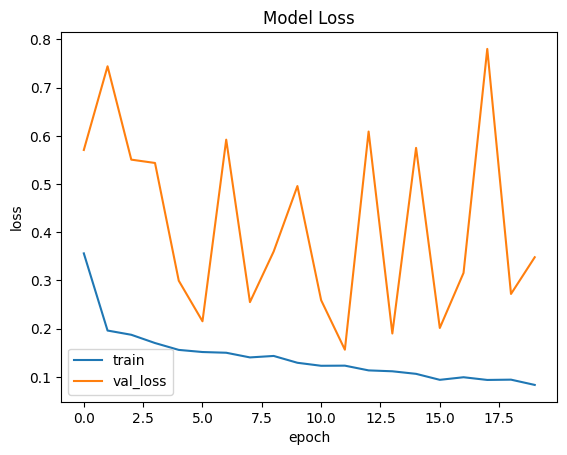

In [44]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()

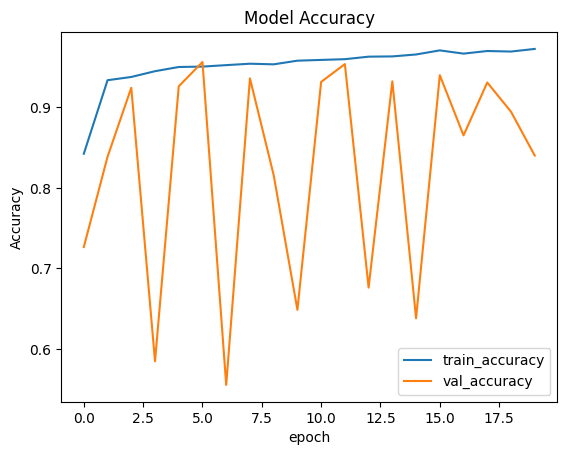

In [45]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

#Model Evaluation and Testing

In [46]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [47]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [48]:
test_dataset = test_dataset.batch(1)

In [49]:
lenet_model.evaluate(test_dataset)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.5091 - loss: 0.6941


[0.6958749890327454, 0.4970972537994385]

In [50]:
lenet_model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


0.54024583

In [51]:
def parasite_or_not(x):
  if x < 0.5:
    return 'P'
  else:
    return 'U'

In [52]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


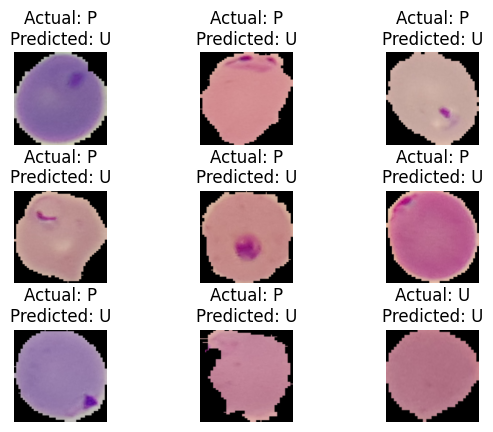

In [53]:
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title("Actual: " + str(parasite_or_not(label.numpy()[0])) + "\n" + "Predicted: " + str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

## ROC and Confusion Matrix

A confusion matrix is a performance measurement tool for machine learning classification problems. It provides a tabular summary of a model's predictions compared to the actual labels in a dataset.

**Structure of a Confusion Matrix:**
For a binary classification problem, the confusion matrix is typically a 2 x 2 table.

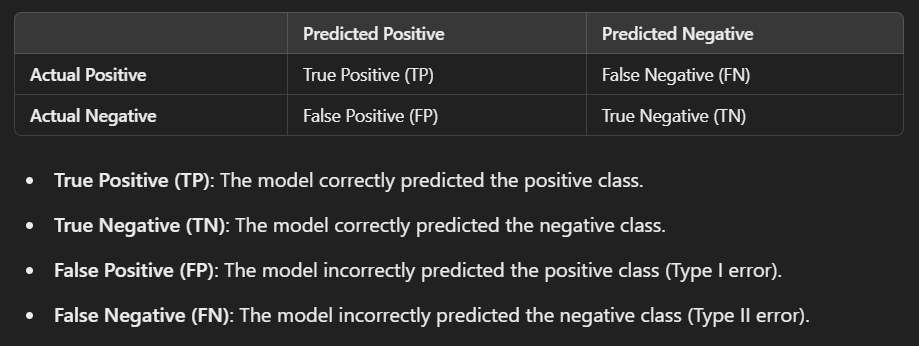

**Metrics Derived from the Confusion Matrix:**
1. **Accuracy:** Measures the proportion of correctly classified instances.

$$
  \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

2. **Precision:** Measures how many of the predicted positives are actually correct.

$$
  \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

3. **Recall (Sensitivity or True Positive Rate):** Measures how many actual positives were correctly identified.

$$
  \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

4. **F1-Score:** Harmonic mean of precision and recall.

$$
  \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

5. **Specificity (True Negative Rate):** Measures how many actual negatives were correctly identified.

$$
  \text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}
$$

**ROC (Receiver Operating Characteristic Curve):**

The **ROC curve** is a graphical representation used to evaluate the performance of a classification model, particularly for binary classification problems. It plots the **True Positive Rate (TPR)** (also called **Recall**) against the **False Positive Rate (FPR)** at various threshold settings.

Key Metrics for the ROC Curve:

1. **True Positive Rate (TPR):** Measures how many actual positives are correctly identified. This is also known as **Recall** or **Sensitivity**.

2. **False Positive Rate (FPR):** Measures the proportion of actual negatives that are incorrectly identified as positives.

$$
  \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

**Key Features of the ROC Curve:**

1. **Diagonal Line (Baseline Performance):**
  * The diagonal line (from (0,0) to (1,1)) represents a random classifier.
  * A model better than random will have its ROC curve above this line.
2. **Area Under the Curve (AUC):**
  * AUC-ROC measures the overall ability of the model to distinguish between classes.
  * Interpretation:
    * **AUC = 1.0:** Perfect classifier.
    * **AUC = 0.5:** Random guessing (no discriminatory power).
    * **0.5<AUC<1.0:** The model performs better than random.

In [72]:
labels = []
input = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  input.append(x)

In [73]:
print(np.array(input).shape)
print(np.array(input)[:,0,...].shape)

(2756, 1, 224, 224, 3)
(2756, 224, 224, 3)


In [74]:
# Convert the first element of each sub-array or sub-list in 'labels' to a 1D NumPy array
# List comprehension to extract the first element (i[0]) from each item (i) in 'labels'
# 'i[0]' assumes each element of 'labels' is an iterable with at least one item

labels = np.array([i[0] for i in labels])
print(labels)

[1 0 0 ... 1 0 0]


In [75]:
predicted = lenet_model.predict(np.array(input)[:,0,...])
print(predicted.shape)
print(predicted[:,0].shape)
print(predicted[:,0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
(2756, 1)
(2756,)
[0.7970753  0.00471488 0.00124205 ... 0.57601887 0.00304217 0.00392184]


324 324 324


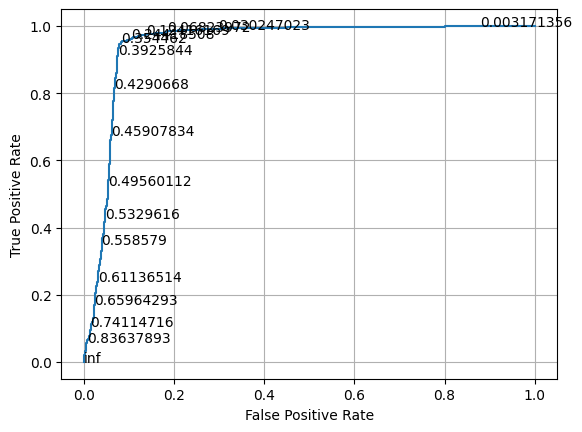

In [76]:
fp, tp, thresholds = roc_curve(labels, predicted)
print(len(fp), len(tp), len(thresholds))

plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])

plt.show()

[[1275  122]
 [  61 1298]]


Text(0.5, 58.7222222222222, 'Predicted')

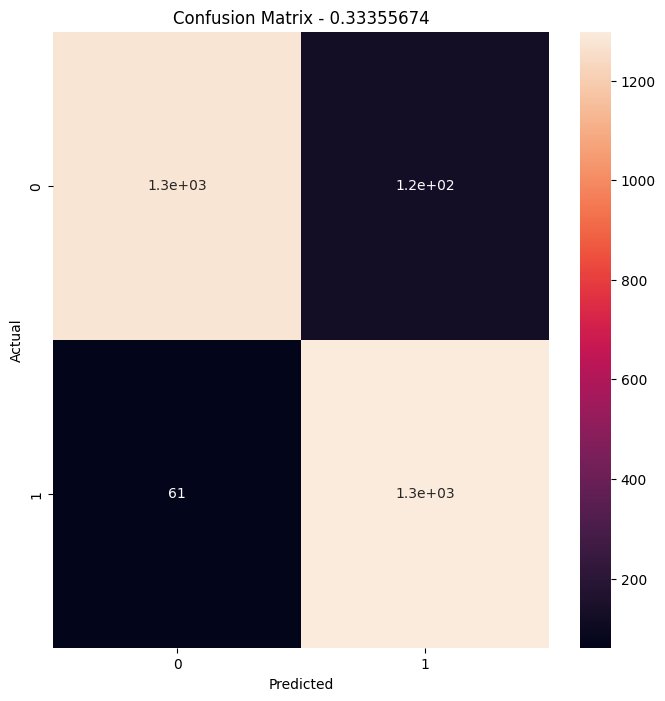

In [77]:
# Define the threshold for classifying predictions
threshold = 0.33355674

# Compute the confusion matrix
# 'labels' are the true values
# 'predicted > threshold' converts predicted probabilities into binary predictions (True/False)
cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title(f'Confusion Matrix - {threshold}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Saving and Loading Models

In [ ]:
# Mount the drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MalariaDiagnosis/

/content/drive/MyDrive/MalariaDiagnosis


In [ ]:
# Save the entire model to a file
lenet_model.save('lenet_model.h5')

In [ ]:
#Saving the history object

import json

with open('lenet_history.json', 'w') as file:
    json.dump(history.history, file)

In [ ]:
import json
# Load the history object
with open('lenet_history.json', 'r') as file:
    history = json.load(file)